In [2]:
import sys, os
sys.path.append("../DLFS_book") # Use this to append directory!!
import numpy as np

In [4]:

from common.functions import *
from common.gradient import numerical_gradient
from common.layers import *
from collections import OrderedDict

In [97]:
class ThreeLayerNet:
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size, weight_init_std=0.01):
        self.params= {}
        
        self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden1_size)
        self.params["b1"] = np.zeros(hidden1_size)
        
        self.params["W2"] = weight_init_std * np.random.randn(hidden1_size, hidden2_size)
        self.params["b2"] = np.zeros(hidden2_size)
        
        self.params["W3"] = weight_init_std * np.random.randn(hidden2_size, output_size)
        self.params["b3"] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params["W1"], self.params["b1"])
        self.layers["Relu1"] = Relu()
        self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])
        self.layers["Sigmoid2"] = Sigmoid()
        self.layers["Affine3"] = Affine(self.params["W3"], self.params["b3"])
        
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y_pred = self.predict(x)
        return self.lastLayer.forward(y_pred, t)
        
    def accuracy(self, x, y):
        y_pred = self.predict(x)
        y_pred = np.argmax(y_pred, axis = 1)
        y = np.argmax(y, axis= 1)
        
        accuracy = np.sum(y_pred == y) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads["W1"]= numerical_gradient(loss_W, self.params["W1"])
        grads["W2"]= numerical_gradient(loss_W, self.params["W2"])
        grads["W3"]= numerical_gradient(loss_W, self.params["W3"])
        
        grads["b1"]= numerical_gradient(loss_W, self.params["b1"])
        grads["b2"]= numerical_gradient(loss_W, self.params["b2"])
        grads["b3"]= numerical_gradient(loss_W, self.params["b3"])
        
        return grads
    
    def gradient(self, x, t):
        loss = self.loss(x, t) #doing this forwards all layers!
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads["W1"] = self.layers["Affine1"].dW                          #store value by ref!!
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW                          #store value by ref!!
        grads["b2"] = self.layers["Affine2"].db
        grads["W3"] = self.layers["Affine3"].dW                          #store value by ref!!
        grads["b3"] = self.layers["Affine3"].db
        
        return grads, loss

In [98]:
net = ThreeLayerNet(input_size=784, hidden1_size = 300, hidden2_size=100, output_size=10) 

In [99]:
net.params["W1"].shape

(784, 300)

In [100]:
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)
y = net.predict(x)
grads, loss = net.gradient(x, t)

#net.params -= alpha * net.grads  # 학습 1번

In [101]:
print(grads["W1"].shape)

(784, 300)


In [102]:
from dataset.mnist import load_mnist
(X_train, t_train), (X_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [103]:
network = ThreeLayerNet(input_size=784, hidden1_size = 300, hidden2_size=100, output_size=10) 

In [104]:
X_batch = X_train[:3]
t_batch = t_train[:3]

In [106]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()
grad_numerical = network.numerical_gradient(X_batch, t_batch)
end = timer()
print("numerical gradient" + " took " + str(timedelta(seconds=end-start)))

start = timer()
grad_backprop, loss = network.gradient(X_batch, t_batch)
end = timer()
print("gradient backpropagation" + " took " + str(timedelta(seconds=end-start)))

numerical gradient took 0:02:03.721325
gradient backpropagation took 0:00:00.002056


In [107]:
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_numerical[key] - grad_backprop[key]))
    print(key, ":", diff)

W1 : 9.503776319537621e-10
W2 : 5.3364813487072873e-11
W3 : 7.276146984729753e-08
b1 : 2.1514211288780165e-08
b2 : 1.0127971820084982e-09
b3 : 1.454427190780705e-07


## Train Our ThreeLayerNet model with mnist

In [108]:
network = ThreeLayerNet(input_size=784, hidden1_size = 300, hidden2_size=100, output_size=10) 

iters_num = 15000 #how many batches shall we use?
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(int(train_size / batch_size), 1) # how many batches per one train data?

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad, loss = network.gradient(X_batch, t_batch)
    
    for key in grad.keys():
        network.params[key] -= learning_rate * grad[key]
        
    train_loss_list.append(loss)
    
    if(i % iter_per_epoch == 0):
        train_acc = network.accuracy(X_train, t_train)
        train_acc_list.append(train_acc)
        test_acc = network.accuracy(X_test, t_test)
        test_acc_list.append(test_acc)
        print(i / iters_num * 100 , "% train accuracy: ", train_acc, " test accuracy: ", test_acc) 


0.0 % train accuracy:  0.10218333333333333  test accuracy:  0.101
4.0 % train accuracy:  0.16115  test accuracy:  0.1586
8.0 % train accuracy:  0.6936  test accuracy:  0.7038
12.0 % train accuracy:  0.8388833333333333  test accuracy:  0.8401
16.0 % train accuracy:  0.8901166666666667  test accuracy:  0.8899
20.0 % train accuracy:  0.91095  test accuracy:  0.9119
24.0 % train accuracy:  0.9238833333333333  test accuracy:  0.9253
28.000000000000004 % train accuracy:  0.93415  test accuracy:  0.9337
32.0 % train accuracy:  0.9417833333333333  test accuracy:  0.942
36.0 % train accuracy:  0.9499  test accuracy:  0.9478
40.0 % train accuracy:  0.9551333333333333  test accuracy:  0.9532
44.0 % train accuracy:  0.9585166666666667  test accuracy:  0.9554
48.0 % train accuracy:  0.9636  test accuracy:  0.9596
52.0 % train accuracy:  0.9659  test accuracy:  0.9607
56.00000000000001 % train accuracy:  0.9698166666666667  test accuracy:  0.965
60.0 % train accuracy:  0.9720833333333333  test accur

loss list


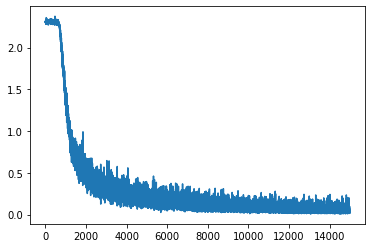

In [109]:
import matplotlib.pyplot as plt
print("loss list")
plt.plot(range(len(train_loss_list)), train_loss_list)

train and test accuracy list


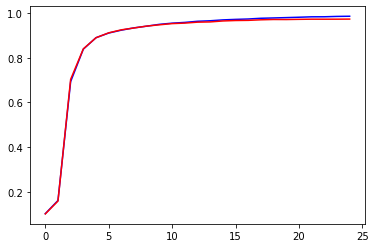

In [110]:
print("train and test accuracy list")
plt.plot(range(len(train_acc_list)), train_acc_list, 'b')
plt.plot(range(len(test_acc_list)), test_acc_list, 'r')

# Almost a perfect Model!